# Aviso
Este notebook é inspirado no codigo disponiblizado em (amazon-sagemaker-examples )[https://github.com/aws/amazon-sagemaker-examples/blob/default/%20%20%20%20%20%20build_and_train_models/sm-hyperparameter_tuning_pytorch/sm-hyperparameter_tuning_pytorch.ipynb]. E **contém algumas modificações**
# Conteúdo do notebook
1. Contexto
2. Configuração
3. Dados
4. Treinamento
5. Host


## Contexto

O MNIST é um conjunto de dados amplamente utilizado para classificação de dígitos manuscritos. Ele consiste em 70.000 imagens rotuladas em escala de cinza, com resolução de 28x28 pixels, de dígitos manuscritos. O conjunto de dados é dividido em 60.000 imagens de treinamento e 10.000 imagens de teste. Existem 10 classes (uma para cada um dos 10 dígitos). Este tutorial mostrará como treinar e testar um modelo MNIST no SageMaker usando PyTorch. Ele também demonstra como usar o SageMaker Automatic Model Tuning para selecionar hiperparâmetros apropriados, a fim de obter o melhor modelo.


# Configuração
O notebook original foi criado e testado em uma instância de notebook ml.m4.xlarge. O  nosso teste vai ocorrer em uma ml.t3.medium

Vamos começar criando uma sessão no SageMaker e especificando:

    - O bucket S3 e o prefixo que você deseja usar para os dados de treinamento e modelo. Isso deve estar na mesma região da instância de notebook, treinamento e hospedagem.
    - O ARN da função IAM usada para fornecer acesso de treinamento e hospedagem aos seus dados. Consulte a documentação para saber como criar essas funções. Nota: se mais de uma função for necessária para instâncias de notebook, treinamento e/ou hospedagem, substitua o sagemaker.get_execution_role() pela(s) string(s) completa(s) apropriada(s) do ARN da função IAM.

    - Se você quiser usar um bucket S3 específico o nome do bucket deve iniciar com a palavra "sagemaker" e ser globalmente exclusivo. Além disso, o bucket deve estar na mesma região da AWS que a instância de notebook usada neste exemplo.

Obs.: **Caso não queira usar seu próprio bucket, o SageMaker vai criar um para você. Para isso remova o default_bucket do sagemaker.Session**

In [1]:
import sagemaker
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
sagemaker_session = sagemaker.Session(default_bucket="sagemaker-teste-aula-pratica")

# sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

region = sagemaker_session.boto_region_name
bucket = sagemaker_session.default_bucket()
prefix = "sagemaker/demo_mnist"

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## Dados

Download do dataset e inserindo no bucket

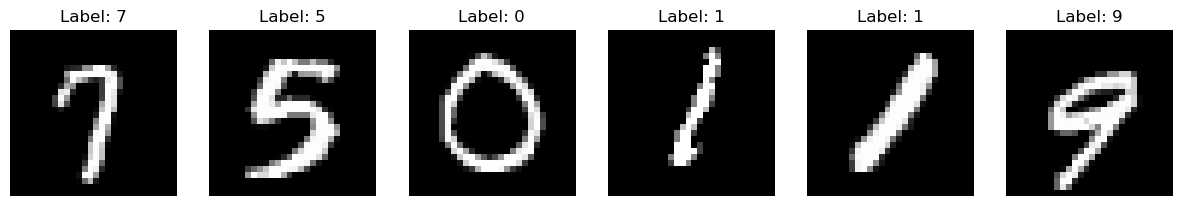

In [2]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

# Carregando o dataset MNIST
train_dataset = MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=10, shuffle=False)

# Visualizando algumas imagens do dataset MNIST
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig, axs = plt.subplots(1, 6, figsize=(15, 3))
for i in range(6):
    axs[i].imshow(example_data[i][0], cmap='gray')
    axs[i].set_title(f'Label: {example_targets[i].item()}')
    axs[i].axis('off')
plt.show()

In [3]:
inputs = sagemaker_session.upload_data(path="data", bucket=bucket, key_prefix=prefix)
print("input spec (in this case, just an S3 path): {}".format(inputs))

input spec (in this case, just an S3 path): s3://sagemaker-teste-aula-pratica/sagemaker/demo_mnist


## Treinamento
Script de treinamento

O script mnist.py fornece todo o código necessário para treinar e hospedar um modelo no SageMaker (a função model_fn carrega o modelo). O script de treinamento é muito semelhante a um script de treinamento que você executaria fora do SageMaker, mas você pode acessar propriedades úteis sobre o ambiente de treinamento por meio de várias variáveis de ambiente, como:

    SM_MODEL_DIR: Uma string que representa o caminho para o diretório onde os artefatos do modelo serão gravados. Esses artefatos são enviados ao S3 para hospedagem do modelo.
    SM_NUM_GPUS: O número de GPUs disponíveis no contêiner atual.
    SM_CURRENT_HOST: O nome do contêiner atual na rede de contêineres.
    SM_HOSTS: Lista codificada em JSON contendo todos os hosts.

Supondo que um canal de entrada, 'training', tenha sido usado na chamada para o método fit(), o seguinte será configurado, seguindo o formato SM_CHANNEL_[nome_do_canal]:

    SM_CHANNEL_TRAINING: Uma string que representa o caminho para o diretório que contém os dados no canal 'training'.

Para mais informações sobre variáveis de ambiente de treinamento, visite SageMaker Containers.

Um script de treinamento típico carrega dados dos canais de entrada, configura o treinamento com hiperparâmetros, treina um modelo e salva o modelo em model_dir para que possa ser hospedado posteriormente. Os hiperparâmetros são passados ao seu script como argumentos e podem ser recuperados com uma instância do argparse.ArgumentParser.

Como o SageMaker importa o script de treinamento, você deve colocar seu código de treinamento dentro de um main guard (if __name__ == '__main__':) se estiver usando o mesmo script para hospedar o modelo, como fazemos neste exemplo. Isso evita que o SageMaker execute inadvertidamente seu código de treinamento no momento errado da execução.

Por exemplo, o script executado por este notebook seria:

In [10]:
!pygmentize src/mnist.py

import argparse
import json
import logging
import os
import sys


import torch
import torch.distributed as dist
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torch.utils.data.distributed
from torchvision import datasets, transforms

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))


# Based on https://github.com/pytorch/examples/blob/master/mnist/main.py
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.f

## Configurar o trabalho de ajuste de hiperparâmetros

**Nota**: com as configurações padrão abaixo, o trabalho de ajuste de hiperparâmetros pode levar cerca de 20 minutos para ser concluído.

Agora que preparamos o conjunto de dados e o script, estamos prontos para treinar os modelos. Antes de fazermos isso, é importante destacar que existem muitos hiperparâmetros que podem afetar drasticamente o desempenho dos modelos treinados. Por exemplo, taxa de aprendizado, tamanho do lote (batch size), número de épocas, etc. Como a melhor configuração de hiperparâmetros depende também do conjunto de dados, é quase impossível escolher a melhor configuração sem realizar uma busca. Usando o **SageMaker Automatic Model Tuning**, podemos criar um trabalho de ajuste de hiperparâmetros para encontrar a melhor configuração de forma automatizada e eficiente.

Neste exemplo, estamos utilizando o **SageMaker Python SDK** para configurar e gerenciar um trabalho de ajuste de hiperparâmetros. Especificamente, definimos um intervalo ou uma lista de valores possíveis no caso de hiperparâmetros categóricos para cada hiperparâmetro que planejamos ajustar. O trabalho de ajuste de hip


In [11]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="./src/mnist.py",
    role=role,
    py_version="py3",
    framework_version="1.8.0",
    instance_count=1,
    instance_type="ml.c5.2xlarge",
    hyperparameters={"epochs": 1, "backend": "gloo"},
)

In [12]:
# test training job

estimator.fit({"training": inputs})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2024-10-23-18-28-59-685


2024-10-23 18:29:02 Starting - Starting the training job...
2024-10-23 18:29:17 Starting - Preparing the instances for training...
2024-10-23 18:29:51 Downloading - Downloading the training image...
2024-10-23 18:30:21 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-10-23 18:30:32,016 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-10-23 18:30:32,019 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-10-23 18:30:32,028 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-10-23 18:30:32,030 sagemaker_pytorch_container.training INFO     Invoking user training script.
2024-10-23 18:30:32,215 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-10-23 18:30:32,228 sagemaker-training-toolkit INFO   

Uma vez que definimos nosso estimador, podemos especificar os hiperparâmetros que gostaríamos de ajustar e seus possíveis valores. Temos três tipos diferentes de hiperparâmetros:

1. **Parâmetros categóricos**: precisam assumir um valor de um conjunto discreto. Definimos isso passando a lista de valores possíveis para `CategoricalParameter(list)`.
2. **Parâmetros contínuos**: podem assumir qualquer valor real entre o valor mínimo e máximo, definido por `ContinuousParameter(min, max)`.
3. **Parâmetros inteiros**: podem assumir qualquer valor inteiro entre o valor mínimo e máximo, definido por `IntegerParameter(min, max)`.

**Nota**: se possível, é quase sempre melhor especificar um valor como o tipo menos restritivo. Por exemplo, ajustar a taxa de aprendizado como um valor contínuo entre 0,01 e 0,2 provavelmente resultará em um desempenho melhor do que ajustá-la como um parâmetro categórico com valores 0,01, 0,1, 0,15 ou 0,2. Especificamos o tamanho do lote como um parâmetro categórico aqui, já que é geralmente recomendado que seja uma potência de 2.


In [13]:
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128, 256, 512]),
}

Em seguida, vamos especificar a métrica de objetivo que gostaríamos de ajustar e sua definição, que inclui a expressão regular (Regex) necessária para extrair essa métrica dos logs do CloudWatch do trabalho de treinamento. Neste caso específico, nosso script emite o valor da perda média e usaremos isso como a métrica de objetivo. Também definimos o `objective_type` como 'minimize', para que o ajuste de hiperparâmetros busque minimizar a métrica de objetivo ao procurar a melhor configuração de hiperparâmetros. Por padrão, o `objective_type` é definido como 'maximize'.


In [14]:
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

Agora, vamos criar um objeto `HyperparameterTuner`, ao qual passamos:

- O estimador PyTorch que criamos anteriormente.
- Nossos intervalos de hiperparâmetros.
- O nome e a definição da métrica de objetivo.
- Configurações de recursos de ajuste, como o número total de trabalhos de treinamento a serem executados e quantos trabalhos de treinamento podem ser executados em paralelo.


In [15]:
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=9,
    max_parallel_jobs=3,
    objective_type=objective_type,
)

## Iniciar o trabalho de ajuste de hiperparâmetros

Finalmente, podemos iniciar nosso trabalho de ajuste de hiperparâmetros chamando `.fit()` e passando o caminho do S3 para nosso conjunto de dados de treino e teste.

Após a criação do trabalho de ajuste de hiperparâmetros, você poderá descrever o trabalho de ajuste para ver seu progresso no próximo passo. Também pode acessar a console do SageMaker em **Jobs** para acompanhar o progresso do trabalho de ajuste de hiperparâmetros.


In [ ]:
tuner.fit({"training": inputs})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: pytorch-training-241023-1831


.....

## Hospedagem
#### Criar endpoint

Após o treinamento, utilizamos o objeto `tuner` para construir e implantar um `PyTorchPredictor`. Isso cria um **Endpoint SageMaker** — um serviço de previsão hospedado que podemos usar para realizar inferências com base no melhor modelo do `tuner`. Lembre-se de que, nos passos anteriores, o `tuner` lançou vários trabalhos de treinamento durante o ajuste, e o modelo resultante com a melhor métrica de objetivo é definido como o melhor modelo.

Conforme mencionado acima, temos a implementação da função `model_fn` no script **mnist.py**, que é necessária. Vamos utilizar as implementações padrão de `input_fn`, `predict_fn`, `output_fn` e `transform_fn` definidas em **sagemaker-pytorch-containers**.

Os argumentos da função `deploy` nos permitem definir o número e o tipo de instâncias que serão usadas para o **Endpoint**. Estas não precisam ser as mesmas que utilizamos para o trabalho de treinamento. Por exemplo, você pode treinar um modelo em um conjunto de instâncias baseadas em GPU e, em seguida, implantar o Endpoint em um conjunto de instâncias baseadas em CPU, mas é necessário garantir que você retorne ou salve seu modelo como um modelo para CPU, semelhante ao que fizemos no **mnist.py**. Aqui, vamos implantar o modelo em uma única instância **ml.m4.xlarge**.


In [ ]:
predictor = tuner.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

### Avaliação

Agora podemos usar este preditor para classificar dígitos escritos à mão.

Você verá uma caixa de imagem vazia após executar a célula abaixo. Em seguida, você pode desenhar um número nela, e os dados de pixel serão carregados em uma variável de dados neste notebook, que podemos então passar para o preditor.


In [ ]:
import gzip
import numpy as np
import random
import os

data_dir = "data/MNIST/raw"
with gzip.open(os.path.join(data_dir, "t10k-images-idx3-ubyte.gz"), "rb") as f:
    images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28).astype(np.float32)

mask = random.sample(range(len(images)), 16)  # randomly select some of the test images
mask = np.array(mask, dtype=np.int)
data = images[mask]

In [ ]:
response = predictor.predict(np.expand_dims(data, axis=1))
print("Raw prediction result:")
print(response)
print()

labeled_predictions = list(zip(range(10), response[0]))
print("Labeled predictions: ")
print(labeled_predictions)
print()

labeled_predictions.sort(key=lambda label_and_prob: 1.0 - label_and_prob[1])
print("Most likely answer: {}".format(labeled_predictions[0]))

In [ ]:
tuner.delete_endpoint()